Inicio e Fim das Atividades

In [12]:
import pandas  
import pm4py  

def import_csv(file_path):
    #Lê o arquivo especificado pelo caminho do arquivo e o carrega em um DataFrame pandas
    event_log = pandas.read_csv(file_path, sep=';')
    
    #Formata o DataFrame para atender aos requisitos do PM4Py, especificando as chaves de caso, atividade e timestamp
    event_log = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
    
    #Obtém as atividades de início e de fim do log de eventos
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    
    #Imprime as atividades de início e de fim
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

if __name__ == "__main__":
    #Chama a função import_csv com o caminho do arquivo CSV fornecido como argumento
    import_csv("C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example_3.csv")


Start activities: {'register request': 6}
End activities: {'reject request': 3, 'pay compensation': 3}


Transforma o arquivo em uma tabela


In [20]:
import pm4py

#Carregando o arquivo CSV como um DataFrame do pandas e formatando-o para um evento log
#Especificando o case_id como 'case_id', a chave de atividade como 'activity' e a chave de timestamp como 'timestamp'  
event_log = pm4py.format_dataframe(pandas.read_csv("C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example_3.csv", sep=';'), case_id='case_id', activity_key='activity', timestamp_key='timestamp')
#Retornando o evento log formatado
event_log

,case_id,activity,timestamp,costs,resource,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,1,register request,2010-12-30 10:02:00+00:00,50,Pete,1,register request,2010-12-30 10:02:00+00:00,0,0
1,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue,1,examine thoroughly,2010-12-31 09:06:00+00:00,1,0
2,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike,1,check ticket,2011-01-05 14:12:00+00:00,2,0
3,1,decide,2011-01-06 10:18:00+00:00,200,Sara,1,decide,2011-01-06 10:18:00+00:00,3,0
4,1,reject request,2011-01-07 13:24:00+00:00,200,Pete,1,reject request,2011-01-07 13:24:00+00:00,4,0
5,2,register request,2010-12-30 10:32:00+00:00,50,Mike,2,register request,2010-12-30 10:32:00+00:00,5,1
6,2,check ticket,2010-12-30 11:12:00+00:00,100,Mike,2,check ticket,2010-12-30 11:12:00+00:00,6,1
7,2,examine casually,2010-12-30 13:16:00+00:00,400,Sean,2,examine casually,2010-12-30 13:16:00+00:00,7,1
8,2,decide,2011-01-05 10:22:00+00:00,200,Sara,2,decide,2011-01-05 10:22:00+00:00,8,1
9,2,pay compensation,2011-01-08 11:05:00+00:00,200,Ellen,2,pay compensation,2011-01-08 11:05:00+00:00,9,1


BPMN Model (xes)

parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 1216.97it/s]


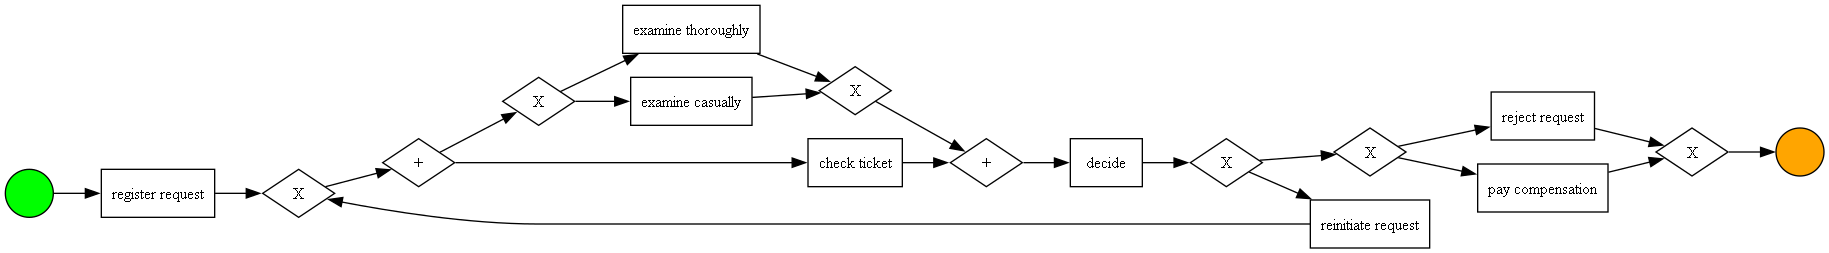

In [ ]:
import pm4py
if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos.
    log = pm4py.read_xes('C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example.xes')

    #Descobre a árvore de processos indutivamente com base no log de eventos.
    #Isso cria uma representação gráfica dos processos subjacentes nos dados do log.
    process_tree = pm4py.discover_process_tree_inductive(log)
    
    #Converte a árvore de processos em um modelo BPMN.
    #Isso permite representar os processos descobertos em um formato padronizado e visualmente compreensível.
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    
    #Exibe o modelo BPMN.
    #Isso permite visualizar os processos descobertos em um formato de diagrama BPMN.
    pm4py.view_bpmn(bpmn_model)


Código Rede de Petri (csv)

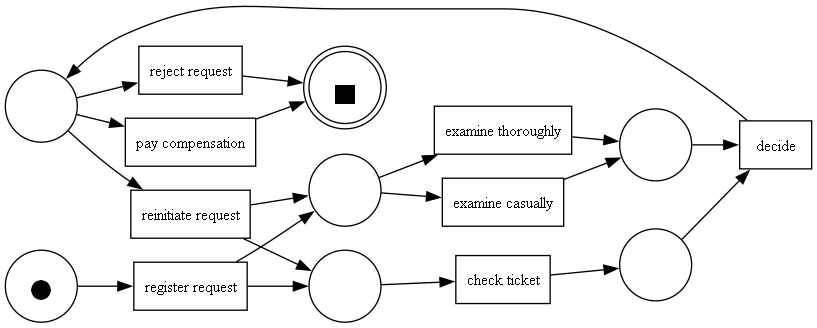

In [ ]:
import pandas as pd
import pm4py
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import os

def import_csv(file_path):
    # Carregar o log de eventos a partir do arquivo CSV
    event_log = pd.read_csv(file_path, sep=';')
    
    # Converter a coluna 'timestamp' para o formato de data/hora
    event_log['timestamp'] = pd.to_datetime(event_log['timestamp'])
    
    # Descobrir o modelo de processo usando o algoritmo Alpha Miner
    event_log = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
    net, initial_marking, final_marking = alpha_miner.apply(event_log)
    
    # Visualizar o modelo de processo
    gviz = pn_visualizer.apply(net, initial_marking, final_marking)
    pn_visualizer.view(gviz)  # Esta linha exibe o gráfico gerado pelo Graphviz

import_csv('C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example_3.csv')



Rede de Petri (xes)

parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 2011.34it/s]


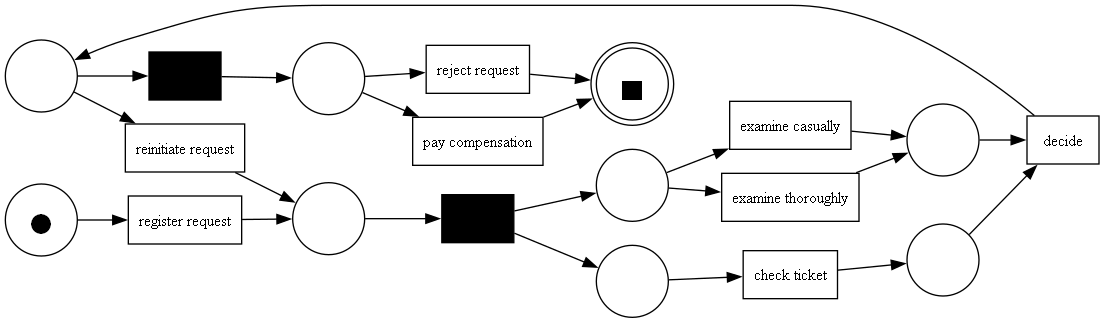

In [ ]:
import pm4py

if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos.
    log = pm4py.read_xes('C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example.xes')

    #Constrói a rede de Petri a partir do log de eventos.
    #A rede de Petri é uma representação gráfica de um sistema de transição de estados.
    petri_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)

    #Exibe a rede de Petri.
    #Isso permite visualizar a estrutura da rede de Petri construída a partir dos dados do log.
    pm4py.view_petri_net(petri_net, initial_marking, final_marking)


Código do Process Map (csv)

In [ ]:
import pandas as pd
import pm4py
from graphviz import Digraph

def import_csv(file_path):
    # Carregar o log de eventos a partir do arquivo CSV
    event_log = pd.read_csv(file_path, sep=';')
    
    # Converter a coluna 'timestamp' para o formato de data/hora
    event_log['timestamp'] = pd.to_datetime(event_log['timestamp'])
    
    # Calcular o tempo gasto em cada ação para todos os pacientes
    action_times = {}
    action_freq = {}
    for action in event_log['activity'].unique():
        action_group = event_log[event_log['activity'] == action]
        action_times[action] = action_group['timestamp'].max() - action_group['timestamp'].min()
        action_freq[action] = len(action_group['case_id'].unique())
    
    # Calcular a frequência e o tempo médio de cada situação
    situation_freq = {}
    situation_times = {}
    for i, situation in event_log[['activity', 'case_id']].drop_duplicates().iterrows():
        situation_group = event_log[(event_log['activity'] == situation['activity']) & (event_log['case_id'] == situation['case_id'])]
        situation_freq[situation['activity']] = len(situation_group['case_id'].unique())
        situation_times[situation['activity']] = (situation_group['timestamp'].max() - situation_group['timestamp'].min()) / situation_freq[situation['activity']]
    
    # Calcular a média dos tempos em horas
    total_time_hours = sum(action_times.values(), pd.Timedelta(0)).total_seconds() / 3600
    num_actions = len(action_times)
    if num_actions != 0:
        average_time_hours = total_time_hours / num_actions
    else:
        average_time_hours = 0
    
    # Descobrir o modelo de processo usando o algoritmo Alpha Miner
    event_log = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
    net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(event_log)
    
    # Criar um objeto Digraph do Graphviz
    dot = Digraph(comment='Process Mining', format='png')
    
    # Adicionar nós ao grafo
    for p in net.places:
        if p.name in situation_times:
            # Adicionar frequência e tempo médio como rótulo do nó
            if situation_times[p.name] >= pd.Timedelta(days=1):
                label = f"{p.name} (Freq.: {situation_freq[p.name]}, Tempo médio: {situation_times[p.name].days:.1f} dias)"
            else:
                label = f"{p.name} (Freq.: {situation_freq[p.name]}, Tempo médio: {situation_times[p.name].seconds / 3600:.1f} horas)"
        else:
            label = p.name
        if p.name == "start":
            dot.node(p.name, label=label, style="filled", fillcolor="green")
        elif p.name == "end":
            dot.node(p.name, label=label, style="filled", fillcolor="green")
        else:
            dot.node(p.name, label=label)

    dot.edge("start", list(net.transitions)[0].name, style="invis")
    dot.edge(list(net.transitions)[-1].name, "end", style="invis")
    
    # Adicionar transições ao grafo
    for t in net.transitions:
        if t.name in action_times:
            label = f"{t.name}\nFreq.: {action_freq[t.name]}\nTempo médio: {action_times[t.name].seconds / 3600:.1f} horas"
        else:
            label = t.name

        dot.node(t.name, label=label, shape='rectangle', style='filled', fillcolor='lightblue')
    
    # Adicionar arestas ao grafo
    for arc in net.arcs:
        dot.edge(arc.source.name, arc.target.name)
       

    # Salvar o gráfico em um arquivo
    dot.render('process_graph', format='png', cleanup=True)
    print("Process graph saved as 'process_graph.png'")

if __name__ == "__main__":
    file_path = "C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example_3.csv"
    import_csv(file_path)

Process graph saved as 'process_graph.png'


Process Tree Model (xes)

parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 1203.01it/s]


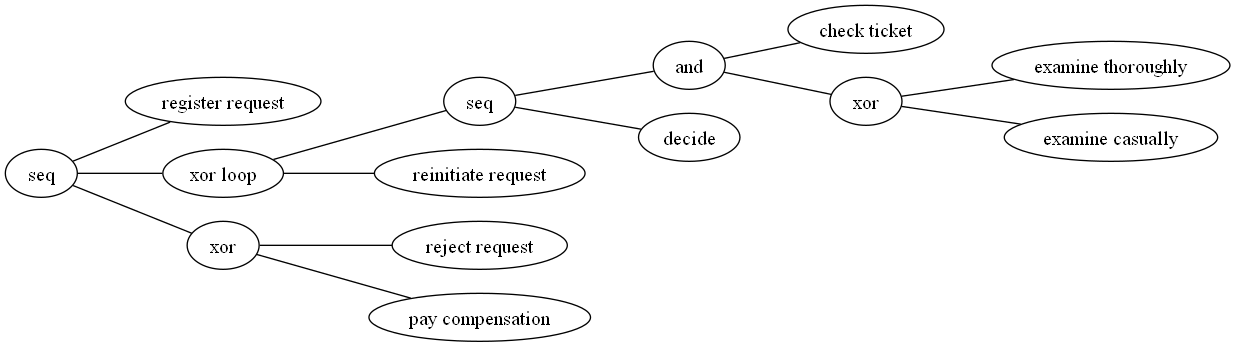

In [ ]:
import pm4py

if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos.
    log = pm4py.read_xes('C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example.xes')

    #Descobre a árvore de processos indutivamente com base no log de eventos.
    #Isso cria uma representação gráfica dos processos subjacentes nos dados do log.
    process_tree = pm4py.discover_process_tree_inductive(log)
    
    #Exibe a árvore de processos.
    #Isso permite visualizar a estrutura dos processos descobertos a partir dos dados do log.
    pm4py.view_process_tree(process_tree)



Process Map DFG-based (xes)

parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 1915.06it/s]


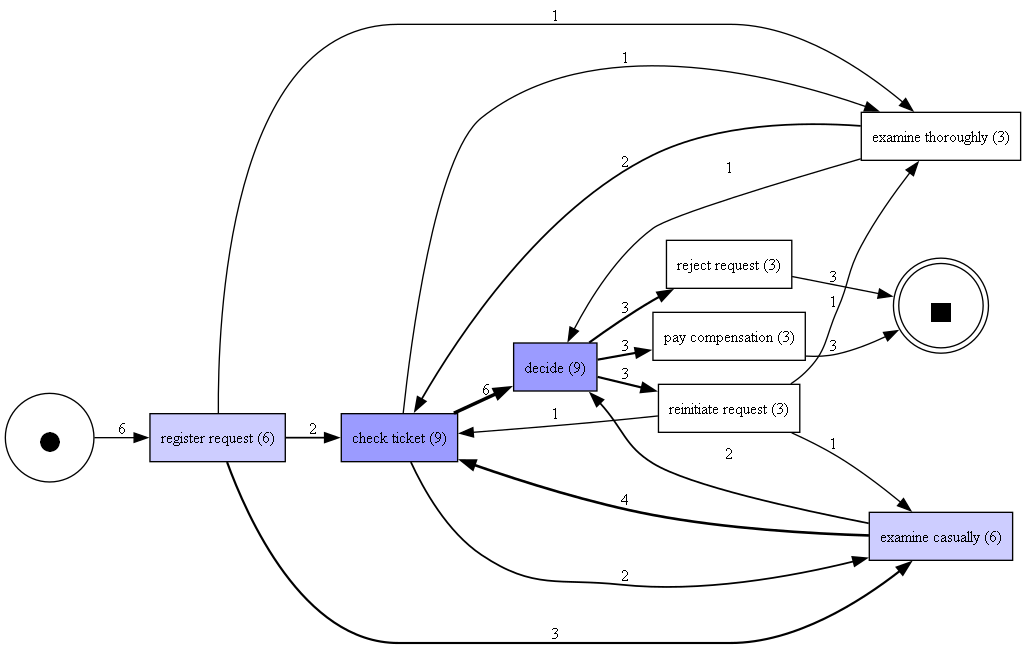

In [ ]:
import pm4py

if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos
    log = pm4py.read_xes('C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example.xes')

    #Descobre o grafo de fluxo direcionado (DFG) e as atividades iniciais e finais.
    #O DFG mostra a relação entre as atividades no log de eventos.
    dfg, start_activities, end_activities = pm4py.discover_dfg(log)
    
    #Exibe o grafo de fluxo direcionado (DFG) juntamente com as atividades iniciais e finais.
    #Isso permite visualizar a sequência de atividades no log de eventos.
    pm4py.view_dfg(dfg, start_activities, end_activities)



Process Map DFG-based (DURAÇÃO)

parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 1985.78it/s]


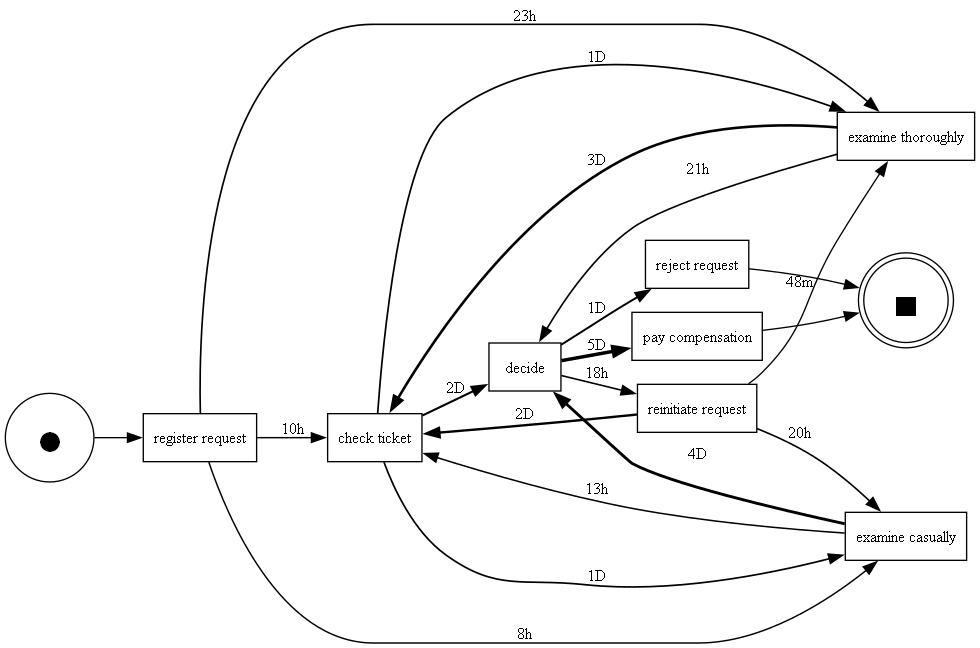

In [17]:
import pm4py

if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos
    log = pm4py.read_xes('C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example.xes')
    performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
    pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

Process Map HM-based (xes)

parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 1446.56it/s]


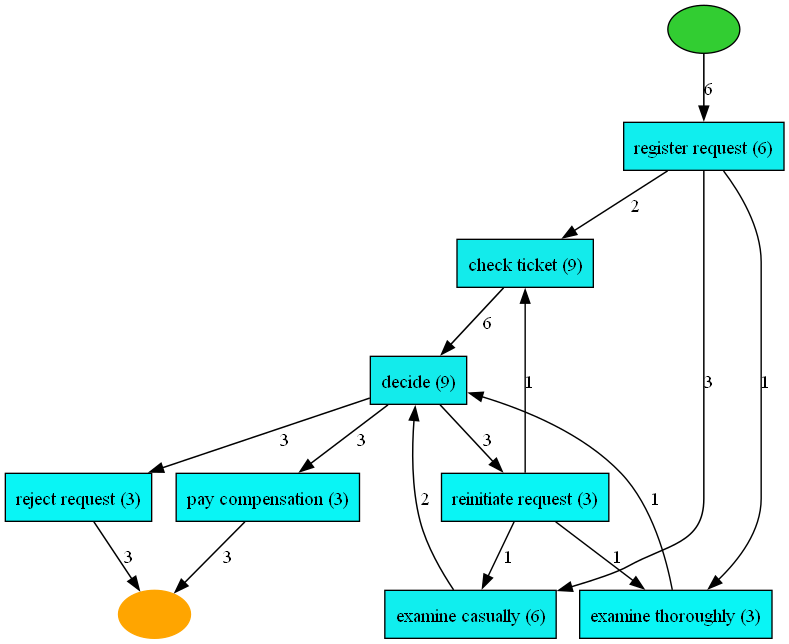

In [11]:
import pm4py

if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos
    log = pm4py.read_xes('C:\\Caio\\grupo-2\\Bases_de_Dados\\running-example.xes')

    #Descobre a rede heurística a partir do log de eventos.
    #A rede heurística é uma representação gráfica de relações entre atividades comuns no log.
    heuristics_net = pm4py.discover_heuristics_net(log)
    #Exibe a rede heurística.
    #Isso permite visualizar as relações entre atividades no log de eventos.
    pm4py.view_heuristics_net(heuristics_net)
